In [273]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [274]:
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [303]:
# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (15, 7))

# Settings for the visualizations
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
plot_params = dict(style='.-', color='0.75', 
                   markeredgecolor='0.25', markerfacecolor='0.25')

In [276]:
# to make this notebook's output stable across runs
seed = 42
np.random.seed(seed)

# Read Data

In [277]:
! ls input

EURGBP.csv                    data_individual_challenge.csv


In [278]:
dtypes = {"Open":"float32",
          "High":"float32",
          "Low":"float32",
          "Close":"float32",
          "rsi":"float32",
          "ema_fast":"float32",
          "ema_slow":"float32",
          "volatility": "float32"}
data = pd.read_csv("input/data_individual_challenge.csv", sep=";",
                   #thousands='.', #decimal: str = ',',
                   dtype=dtypes,
                   parse_dates=['Date'], infer_datetime_format=True)
data.Date = data.Date.dt.to_period('D')
data = data.set_index('Date')
display(data.head())
display(data.info())

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility
Date,,,,,,,,
2000-01-03,0.6281,633.00000,0.6235,0.6272,NaN,NaN,NaN,NaN
2000-01-10,0.6271,629.00000,0.6181,0.6197,NaN,NaN,NaN,NaN
2000-01-17,0.6200,0.62250,0.6072,609.0000,NaN,NaN,NaN,NaN
2000-01-24,0.6091,0.61271,599.0000,0.6027,NaN,NaN,NaN,NaN
2000-01-31,0.6021,0.62670,598.0000,0.6158,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1035 entries, 2000-01-03 to 2019-10-28
Freq: D
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1035 non-null   float32
 1   High        1035 non-null   float32
 2   Low         1035 non-null   float32
 3   Close       1035 non-null   float32
 4   rsi         1021 non-null   float32
 5   ema_fast    1022 non-null   float32
 6   ema_slow    994 non-null    float32
 7   volatility  1021 non-null   float32
dtypes: float32(8)
memory usage: 40.4 KB


None

In [279]:
features = ['Open', 'High', 'Low', 'Close', 'rsi', 'ema_fast', 'ema_slow',
       'volatility']
n_features = len(features)
feats_raw = ["Open", "High", "Low", "Close"]
feats_avgs = ["rsi", "ema_fast", "ema_slow", "volatility"]

# Observations
- NA in: rsi	ema_fast	ema_slow	volatility	target
- explore object columns: rsi	ema_fast	ema_slow	volatility

# Data Exploration

<AxesSubplot:xlabel='Date'>

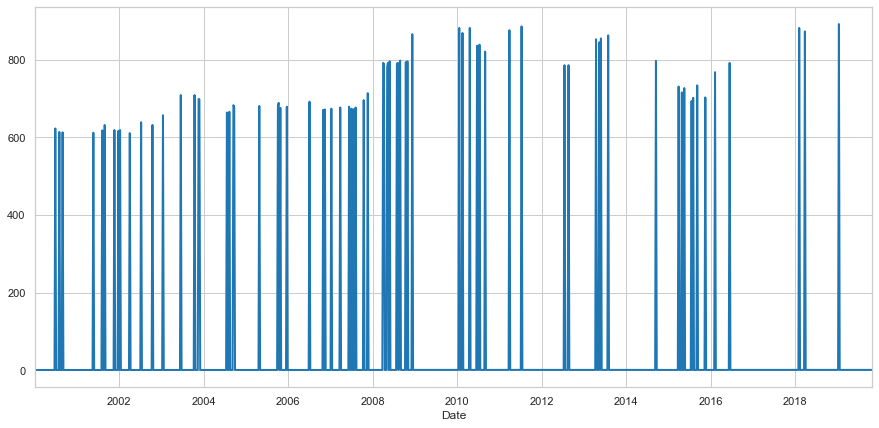

In [280]:
data.Open.plot()

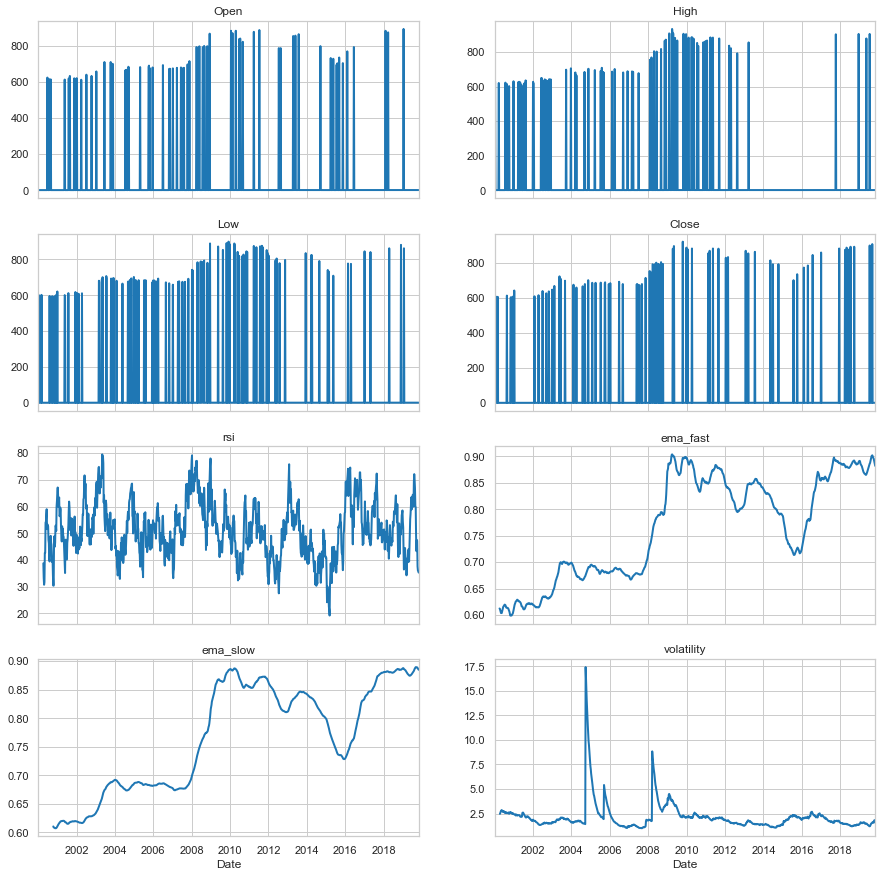

In [281]:
fig, axs = plt.subplots(4, 2, figsize=(15,15), sharex=True)
i=0
for col in features:
    ax=axs.flat[i]
    data[col].plot(ax=ax)
    ax.set_title(col)
    i += 1

# Outliers

In [282]:
from scipy import stats

X = data[feats_raw].copy()

z = np.abs(stats.zscore(X))
df_z = pd.DataFrame(z, columns=X.columns, index=X.index)

z_lim = 2
X_o = X[(z > z_lim).any(axis=1)]
X = X.drop(X_o.index)

In [283]:
X_o

,Open,High,Low,Close
Date,,,,
2000-01-03,0.62810,633.00000,0.62350,0.62720
2000-01-10,0.62710,629.00000,0.61810,0.61970
2000-01-17,0.62000,0.62250,0.60720,609.00000
2000-01-24,0.60910,0.61271,599.00000,0.60270
2000-01-31,0.60210,0.62670,598.00000,0.61580
...,...,...,...,...
2019-01-14,892.00000,0.89511,0.87708,0.87720
2019-01-21,0.88420,0.88618,862.00000,0.86340
2019-05-13,0.86373,879.00000,0.86240,0.87303


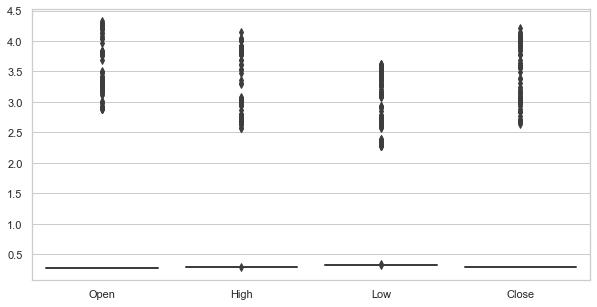

In [284]:
fig, ax = plt.subplots(figsize=(10,5))
ax=sns.boxplot(data=df_z, ax=ax)

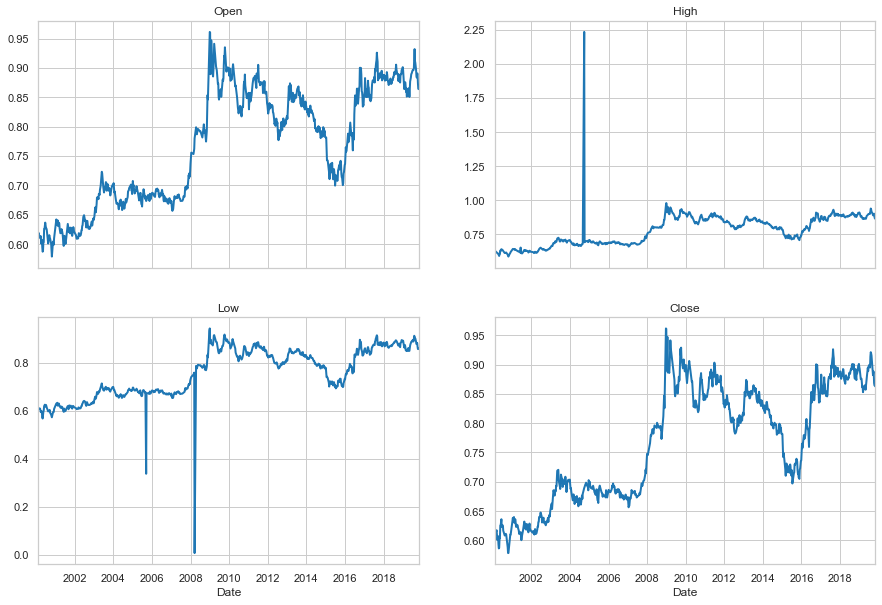

In [285]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
i=0
for col in feats_raw:
    ax=axs.flat[i]
    ax=X[col].plot(ax=ax)
    ax.set_title(col)
    i += 1

<AxesSubplot:>

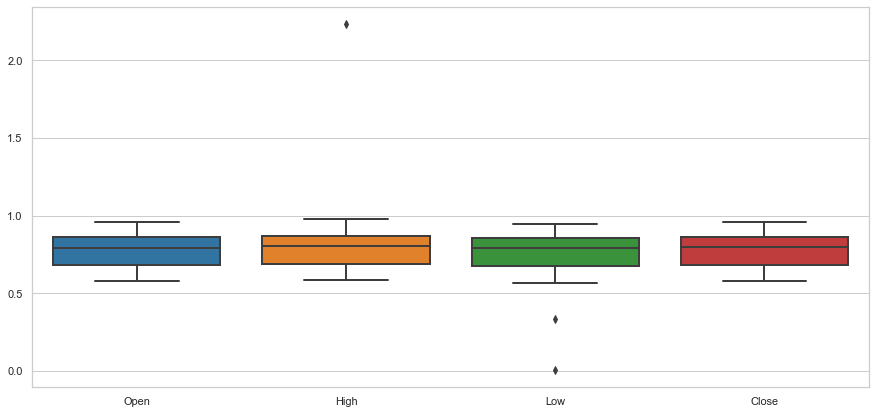

In [286]:
sns.boxplot(data=X)

In [287]:
new_o = X[((X>1.5) | (X<0.5)).any(axis=1)]
new_o

,Open,High,Low,Close
Date,,,,
2004-09-27,0.6800,2.2335,0.6781,0.6895
2005-09-12,0.6733,0.6787,0.3375,0.6744
2008-03-17,0.7800,0.7908,0.0066,0.7783


In [288]:
X_o = X_o.append(new_o)
X_o = X_o.sort_index()
X = X.drop(new_o.index)

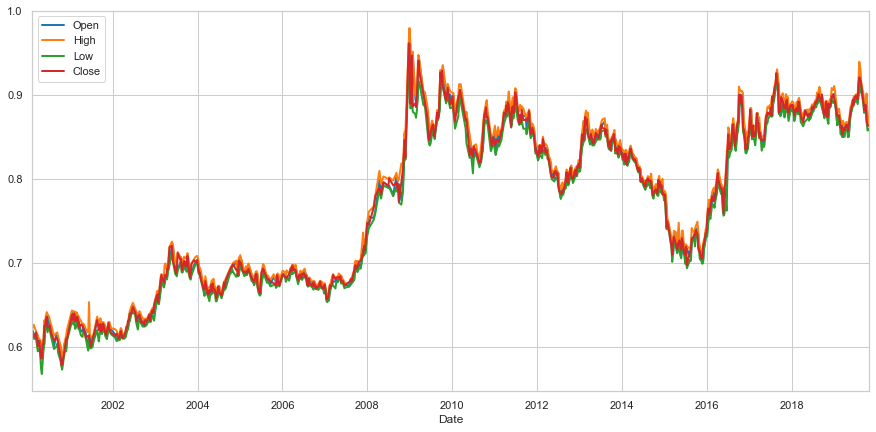

In [289]:
fig, ax = plt.subplots()
for col in feats_raw:
    ax = X[col].plot(ax=ax)
    ax.legend()

In [290]:
avg_price = X.mean(axis=1)
avg_price

Date
2000-02-07    0.616725
2000-02-14    0.617450
2000-02-21    0.616000
2000-03-13    0.613925
2000-03-27    0.605775
                ...   
2019-09-30    0.888697
2019-10-07    0.882258
2019-10-14    0.869457
2019-10-21    0.863225
2019-10-28    0.862870
Freq: D, Length: 734, dtype: float32

<AxesSubplot:xlabel='Date'>

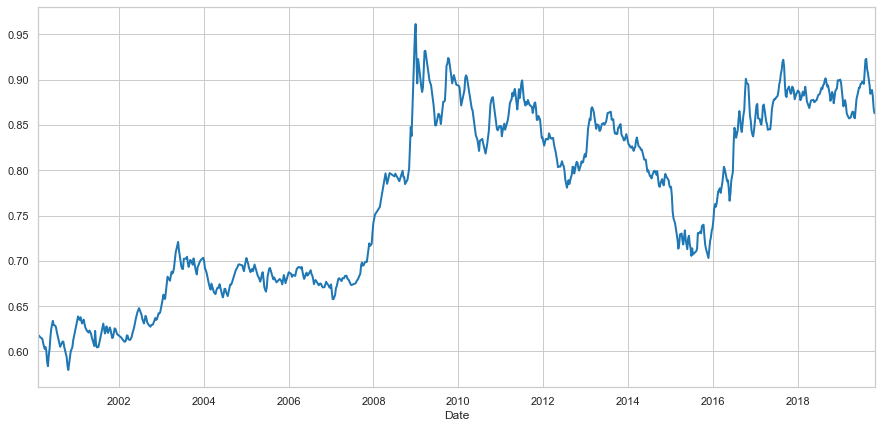

In [291]:
avg_price.plot()

In [293]:
data_clean = data.loc[X.index]

# Time series

In [299]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

In [296]:
y = data_clean[feats_raw].mean(axis=1)
y.name = "Price"

In [297]:
dp = DeterministicProcess(index = y.index,
                          constant=True,
                          order=1,
                          seasonal=True,
                          drop=True
                         )
X = dp.in_sample()

In [305]:
model = LinearRegression()
model.fit(X, y)
y_fit = pd.Series(model.predict(X), index=y.index, name="Fit")

Text(0.5, 1.0, 'Average price time evolution')

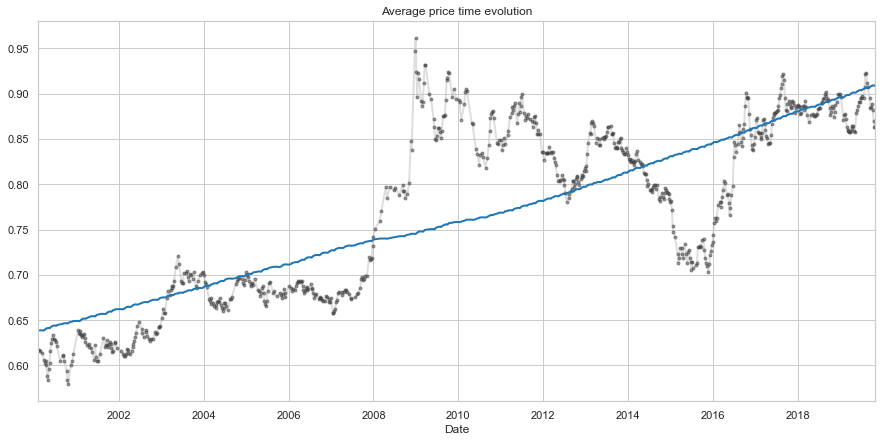

In [308]:
ax=y.plot(**plot_params, alpha=.5)
ax=y_fit.plot(ax=ax)
ax.set_title("Average price time evolution")

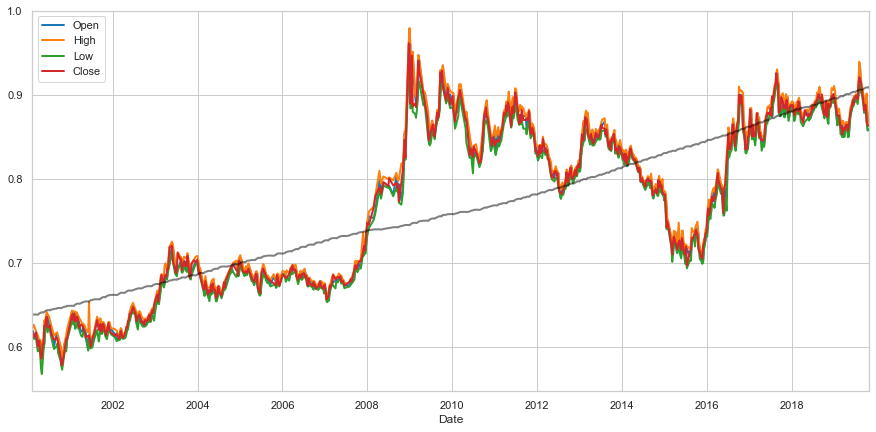

In [312]:
fig, ax = plt.subplots()
for col in feats_raw:
    ax = data_clean[col].plot(ax=ax)
    ax.legend()
ax=y_fit.plot(ax=ax, alpha=0.5, color="black")

# Current years analysis

In [323]:
df = data_clean.loc['2017-07':]
X = df[feats_raw]
y = X.mean(axis=1)
y.name="Price"

<AxesSubplot:xlabel='Date'>

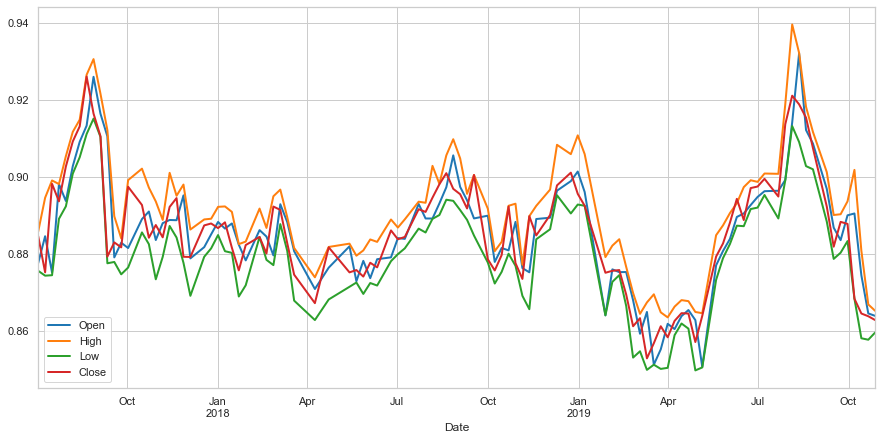

In [324]:
X.plot()

<AxesSubplot:xlabel='Date'>

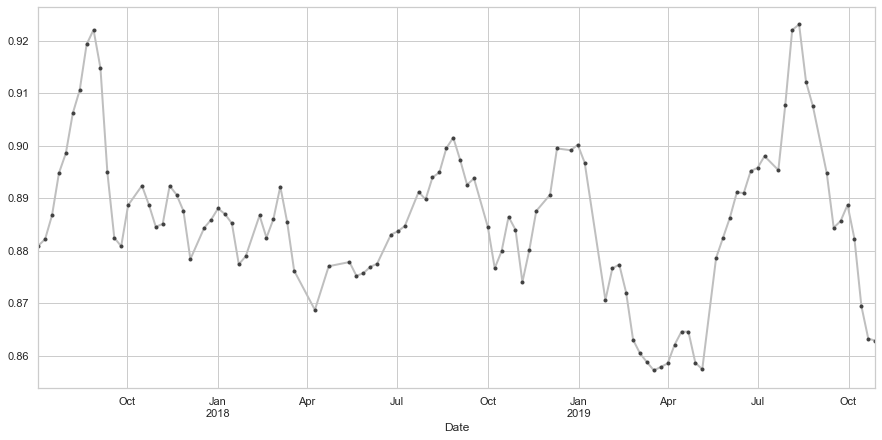

In [325]:
y.plot(**plot_params)

In [351]:
f1 = CalendarFourier(freq='A', order=4)
dp = DeterministicProcess(index = y.index,
                          constant=False,
                          order=0,
                          seasonal=False,
                          drop=True,
                          additional_terms=[f1]
                         )
X = dp.in_sample()
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
y_fit = pd.Series(model.predict(X), index=y.index, name="Fit")

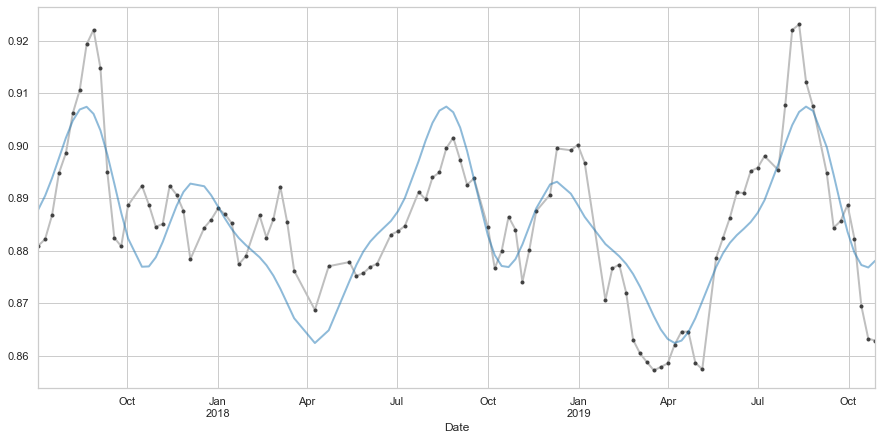

In [353]:
fig, ax = plt.subplots()
ax = y.plot(ax=ax, **plot_params)
ax=y_fit.plot(ax=ax, alpha=0.5)

# Indexes analysis

In [361]:
df = data_clean[feats_avgs]

<AxesSubplot:xlabel='Date'>

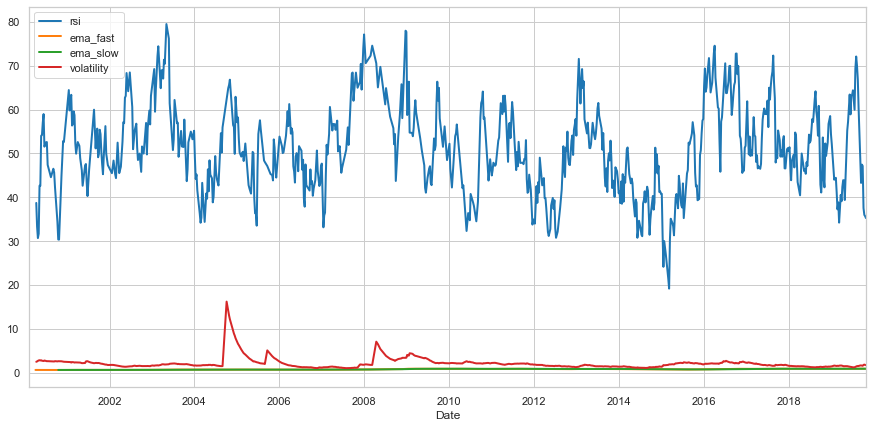

In [362]:
df.plot()

In [376]:
# RSI
y = df['rsi']
y.name="rsi"
y = y.dropna()
rsi_mean = y.mean()
rsi_mean
y_deseason = y-rsi_mean

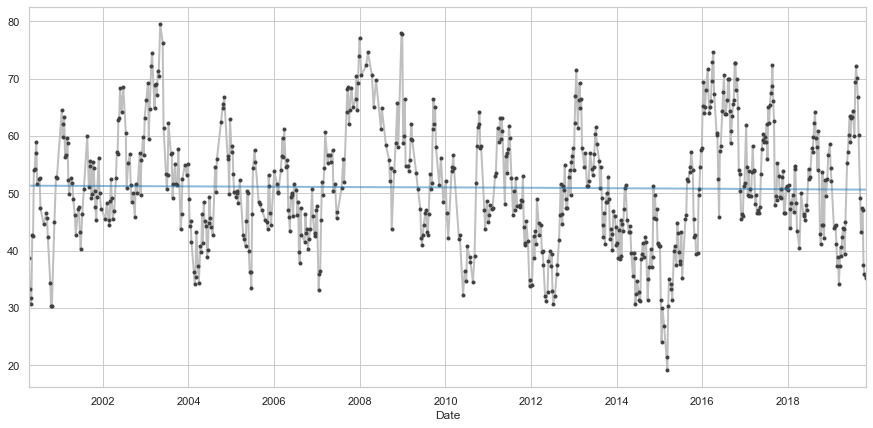

In [377]:
fig, ax = plt.subplots()
ax = y.plot(ax=ax, **plot_params)
ax=y_fit.plot(ax=ax, alpha=0.5)

<AxesSubplot:xlabel='Date'>

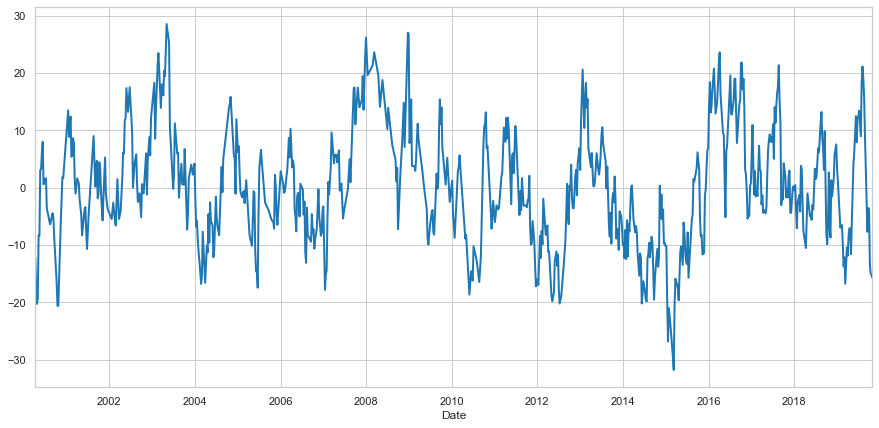

In [378]:
y_deseason.plot()

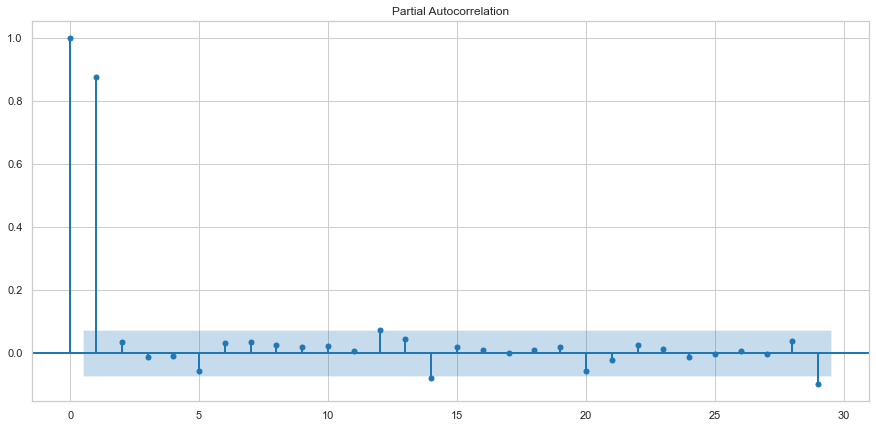

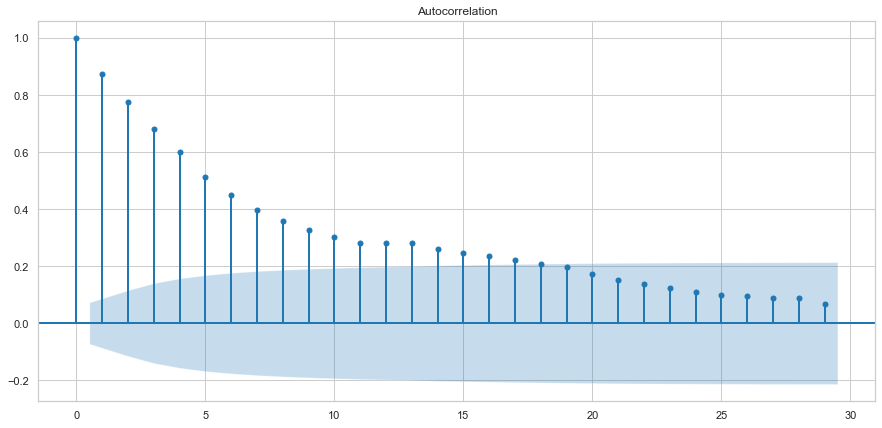

In [385]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf=plot_pacf(y_deseason)
acf=plot_acf(y_deseason)
# AR order 1
# MA order 15

# Combine indexes with avg price

In [394]:
df = data_clean.copy()
df['mean_price'] = data_clean[feats_raw].mean(axis=1)
df = df.dropna()
df['dif_fast_slow'] = df.ema_fast - df.ema_slow
df

,Open,High,Low,Close,rsi,ema_fast,ema_slow,volatility,mean_price,dif_fast_slow
Date,,,,,,,,,,
2000-10-16,0.58820,0.59230,0.57750,0.57850,30.382368,0.602323,0.610376,2.605170,0.584125,-0.008053
2000-10-23,0.57860,0.58760,0.57310,0.57840,30.343134,0.599133,0.608889,2.598570,0.579425,-0.009756
2000-11-13,0.60420,0.60520,0.59410,0.59660,44.936329,0.599244,0.607640,2.586345,0.600025,-0.008396
2000-11-27,0.59880,0.61430,0.59520,0.61000,52.819202,0.600639,0.607362,2.506936,0.604575,-0.006724
2000-12-04,0.60990,0.62080,0.60790,0.60970,52.635273,0.601847,0.607471,2.480143,0.612075,-0.005624
...,...,...,...,...,...,...,...,...,...,...
2019-09-30,0.89002,0.89365,0.88333,0.88779,47.151897,0.895761,0.889108,1.564625,0.888697,0.006653
2019-10-07,0.89050,0.90183,0.86835,0.86835,37.551960,0.892106,0.888143,1.760790,0.882258,0.003963
2019-10-14,0.87443,0.88081,0.85808,0.86451,35.993099,0.888426,0.887044,1.830085,0.869457,0.001383


In [409]:
idx_up = df[df.dif_fast_slow > 0].index
idx_down = df[df.dif_fast_slow <= 0].index

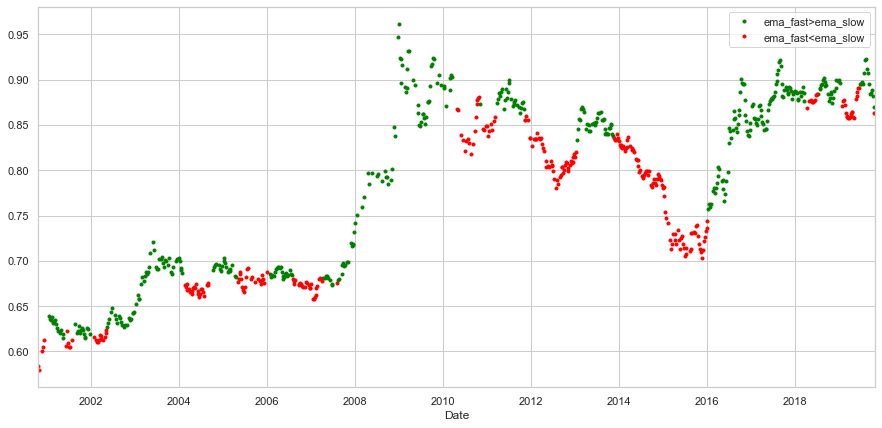

In [416]:
ax = df.loc[idx_up,"mean_price"].plot(style='g.', )
ax=df.loc[idx_down,"mean_price"].plot(style='r.', ax=ax)
ax.legend(["ema_fast>ema_slow", "ema_fast<ema_slow"])

<AxesSubplot:xlabel='Date'>

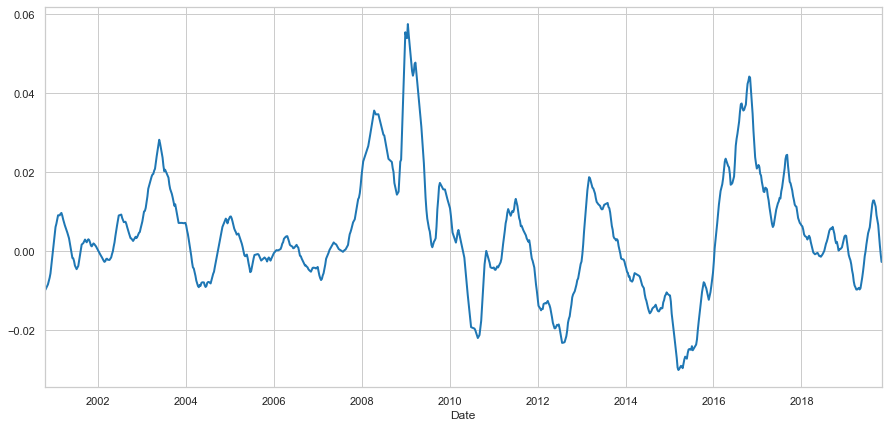

In [413]:
df.dif_fast_slow.plot()

Text(0, 0.5, 'ema_fast - ema_slow')

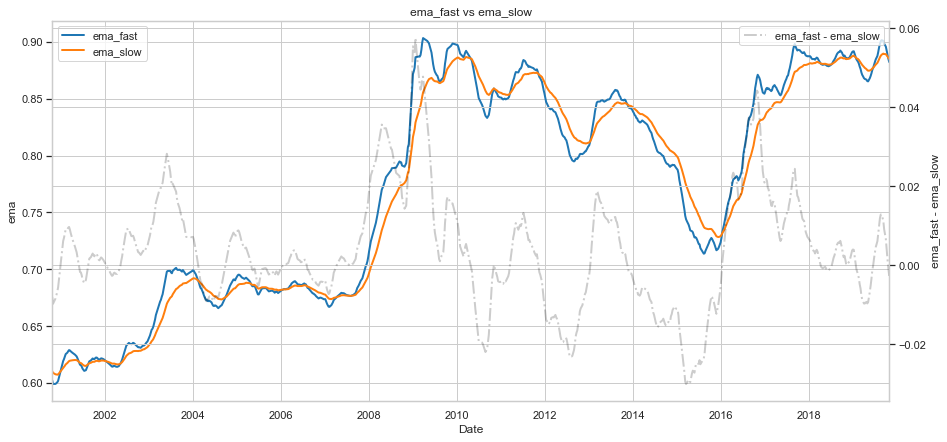

In [432]:
ax = df.ema_fast.plot()
ax = df.ema_slow.plot(ax=ax)
ax.set_title("ema_fast vs ema_slow")
ax.set_ylabel("ema")

ax2=ax.twinx()
ax2 = df.dif_fast_slow.plot( ax=ax2, color="black", style="-.", alpha=.2)
ax.legend(["ema_fast", "ema_slow","ema_fast - ema_slow"])
ax2.legend(["ema_fast - ema_slow"])
ax2.set_ylabel("ema_fast - ema_slow")

# Diferenciate  prices

In [445]:
y = data_clean.ema_fast.copy()
y = pd.DataFrame(y - y.shift(1))
y = y.dropna()
y = y.join(data_clean.volatility)
y

,ema_fast,volatility
Date,,
2000-04-10,-6.781220e-04,2.472826
2000-04-17,-2.374351e-03,2.553710
2000-04-24,-3.057778e-03,2.686717
2000-05-01,-2.476692e-03,2.783464
2000-05-08,1.192093e-07,2.830441
...,...,...
2019-09-30,-1.226246e-03,1.564625
2019-10-07,-3.654778e-03,1.760790
2019-10-14,-3.679454e-03,1.830085


(0.0, 4.0)

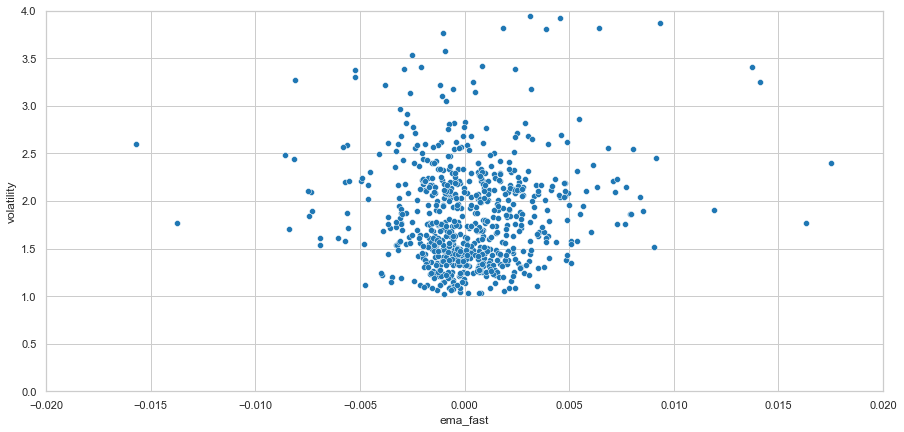

In [453]:
ax = sns.scatterplot(data=y, x="ema_fast", y="volatility")
ax.set_xlim([-0.02,0.02])
ax.set_ylim([0,4])

<AxesSubplot:xlabel='Date'>

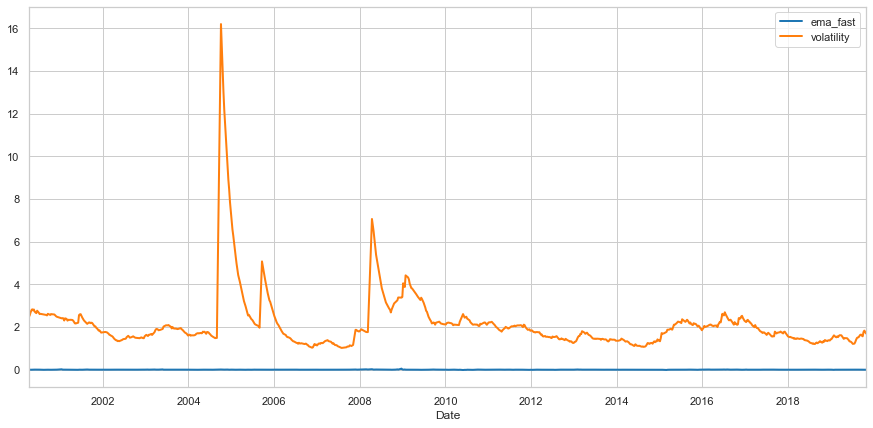

In [454]:
y.plot()

Text(0.5, 1.0, 'price vs volatility')

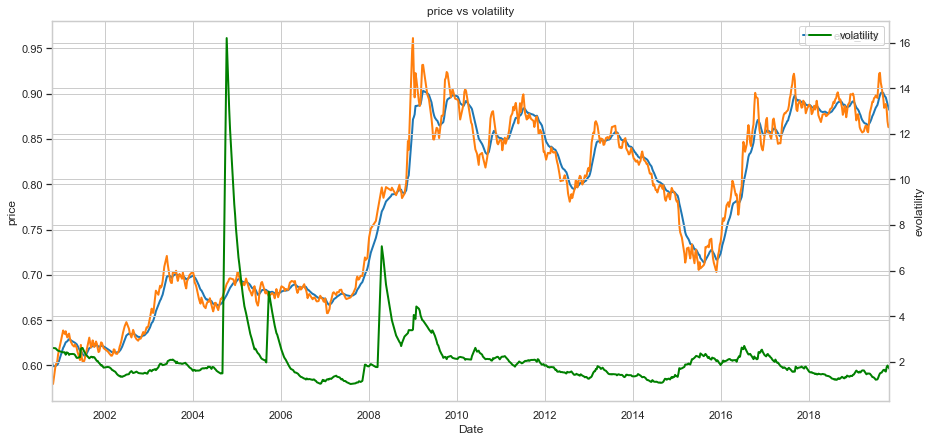

In [463]:
ax = df["ema_fast"].plot()
ax = df["mean_price"].plot()
ax.set_ylabel("price")

ax2=ax.twinx()
ax2 = df["volatility"].plot(color="g")
ax.legend(["ema_fast"])
ax2.legend(["volatility"])
ax2.set_ylabel("evolatility")


ax.set_title("price vs volatility")